# Лабораторная работа 3

1) Полносвязная нейронная сеть ( Fully-Connected Neural Network)

2) Нормализация по мини-батчам (Batch normalization)

3) Dropout

4) Сверточные нейронные сети (Convolutional Networks)

Лабораторные работы можно выполнять с использованием сервиса Google Colaboratory (https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) или на локальном компьютере. 

# Полносвязная нейронная сеть

В данной лабораторной работе необходимо будет реализовать полносвязную нейронную сеть, используя модульный подход. Для каждого  слоя реализации прямого и обратного проходов алгоритма обратного распространения ошибки будут иметь следующий вид:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```



```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

    

In [17]:
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from scripts.classifiers.fc_net import *

from scripts.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from scripts.solver import Solver
from scripts.classifiers.cnn import *
from scripts.layers import *
from scripts.fast_layers import *


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))
def print_mean_std(x,axis=0):
    print('  means: ', x.mean(axis=axis))
    print('  stds:  ', x.std(axis=axis))
    print() 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Загрузите данные из предыдущей лабораторной работы. 

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
mnist_digits = load_digits()
# num_classes = mnist_digits['target_names']

samples = mnist_digits['data']

target_samples = mnist_digits['target']
# Разделение данных на обучающую и временную выборки (80% на обучение, 20% на временную выборку)
X_train, X_temp, y_train, y_temp = train_test_split(samples, target_samples, test_size=0.201, random_state=33)

# Разделение временной выборки на тестовую и валидационную выборки (50% на каждую)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=33)
# Вывод размеров выборок
print("Размеры обучающей выборки:", X_train.shape)
print("Размеры тестовой выборки:", X_test.shape)
print("Размеры валидационной выборки:", X_val.shape)

# Сохранение данных в словаре data
data = {
    'X_train': X_train,
    'y_train': y_train,
    'X_val': X_val,
    'y_val': y_val,
    'X_test': X_test,
    'y_test': y_test
}

Размеры обучающей выборки: (1435, 64)
Размеры тестовой выборки: (181, 64)
Размеры валидационной выборки: (181, 64)


Для полносвязного слоя реализуйте прямой проход (метод affine_forward в scripts/layers.py). Протестируйте свою реализацию. 

In [3]:
num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])


print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


Для полносвязного слоя реализуйте обратный проход (метод affine_backward в scripts/layers.py). Протестируйте свою реализацию. 

In [4]:
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


Реализуйте прямой проход для слоя активации ReLU (relu_forward) и протестируйте его.

In [5]:
x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


Реализуйте обратный проход для слоя активации ReLU (relu_backward ) и протестируйте его.

In [6]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


В скрипте /layer_utils.py приведены реализации прямого и обратного проходов для часто используемых комбинаций слоев. Например, за полносвязным слоем часто следует слой активации. Ознакомьтесь с функциями affine_relu_forward и affine_relu_backward, запустите код ниже и убедитесь, что ошибка порядка e-10 или ниже. 

In [7]:
from scripts.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  2.299579177309368e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


Реализуйте двухслойную полносвязную сеть - класс TwoLayerNet в scripts/classifiers/fc_net.py . Проверьте свою реализацию, запустив код ниже. 

In [8]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 3.12e-10
b1 relative error: 9.83e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 2.85e-08
b1 relative error: 1.56e-08
b2 relative error: 7.76e-10


Ознакомьтесь с API для обучения и тестирования моделей в scripts/solver.py . Используйте экземпляр класса Solver для обучения двухслойной полносвязной сети. Необходимо достичь минимум 50% верно классифицированных объектов на валидационном наборе. 

In [9]:
model = TwoLayerNet()
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

model = TwoLayerNet(input_dim=64, hidden_dim=20, num_classes=10, weight_scale=1e-2, reg=0.01)

learning_rate = 1e-3
solver = Solver(model, data,
                print_every=10, num_epochs=80, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4560) loss: 2.295445
(Epoch 0 / 80) train acc: 0.106000; val_acc: 0.099448
(Iteration 11 / 4560) loss: 2.304630
(Iteration 21 / 4560) loss: 2.302332
(Iteration 31 / 4560) loss: 2.301750
(Iteration 41 / 4560) loss: 2.297262
(Iteration 51 / 4560) loss: 2.299604
(Epoch 1 / 80) train acc: 0.236000; val_acc: 0.259669
(Iteration 61 / 4560) loss: 2.295343
(Iteration 71 / 4560) loss: 2.307107
(Iteration 81 / 4560) loss: 2.291783
(Iteration 91 / 4560) loss: 2.293360
(Iteration 101 / 4560) loss: 2.294797
(Iteration 111 / 4560) loss: 2.292340
(Epoch 2 / 80) train acc: 0.314000; val_acc: 0.287293
(Iteration 121 / 4560) loss: 2.289673
(Iteration 131 / 4560) loss: 2.288820
(Iteration 141 / 4560) loss: 2.290154
(Iteration 151 / 4560) loss: 2.298133
(Iteration 161 / 4560) loss: 2.291259
(Iteration 171 / 4560) loss: 2.291636
(Epoch 3 / 80) train acc: 0.310000; val_acc: 0.292818
(Iteration 181 / 4560) loss: 2.279893
(Iteration 191 / 4560) loss: 2.279668
(Iteration 201 / 4560) loss: 2.2668

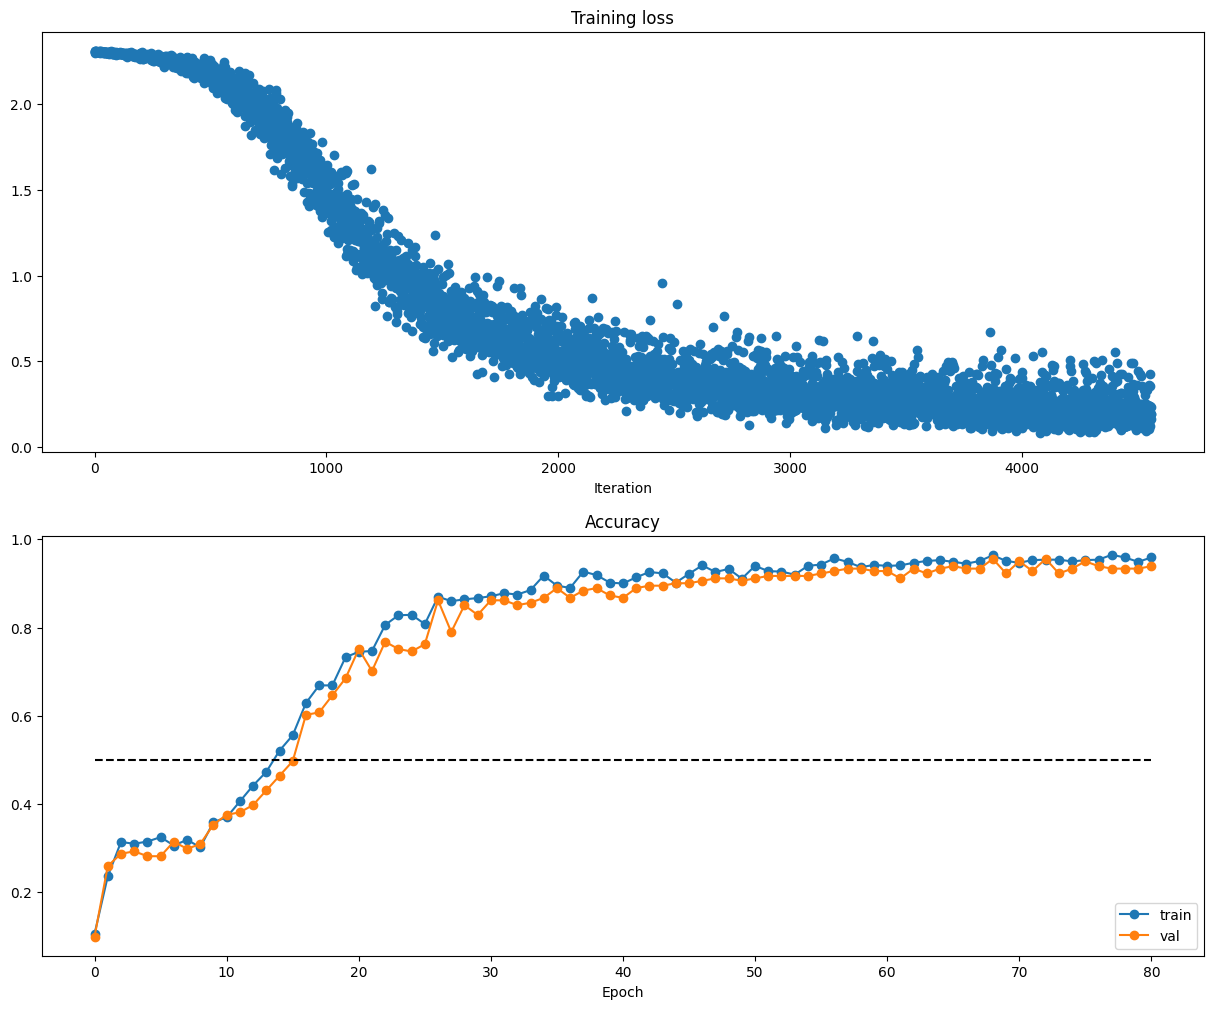

In [10]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

Теперь реализуйте полносвязную сеть с произвольным числом скрытых слоев. Ознакомьтесь с классом FullyConnectedNet в scripts/classifiers/fc_net.py . Реализуйте инициализацию, прямой и обратный проходы.

In [11]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Most of the errors should be on the order of e-7 or smaller.   
  # NOTE: It is fine however to see an error for W2 on the order of e-5
  # for the check when reg = 0.0
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  5.940411485412347
W1 relative error: 6.59e-09
W2 relative error: 5.91e-08
W3 relative error: 3.80e-07
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.80e-10


Попробуйте добиться эффекта переобучения на небольшом наборе изображений (например, 50). Используйте трехслойную сеть со 100 нейронами на каждом скрытом слое. Попробуйте переобучить сеть, достигнув 100 % accuracy за 20 эпох. Для этого поэкспериментируйте с параметрами weight_scale и learning_rate. 

(Iteration 1 / 40) loss: 4.461531
(Epoch 0 / 20) train acc: 0.240000; val_acc: 0.187845
(Epoch 1 / 20) train acc: 0.300000; val_acc: 0.171271
(Epoch 2 / 20) train acc: 0.460000; val_acc: 0.287293
(Epoch 3 / 20) train acc: 0.500000; val_acc: 0.237569
(Epoch 4 / 20) train acc: 0.760000; val_acc: 0.419890
(Epoch 5 / 20) train acc: 0.700000; val_acc: 0.441989
(Iteration 11 / 40) loss: 1.395183
(Epoch 6 / 20) train acc: 0.720000; val_acc: 0.441989
(Epoch 7 / 20) train acc: 0.780000; val_acc: 0.502762
(Epoch 8 / 20) train acc: 0.900000; val_acc: 0.563536
(Epoch 9 / 20) train acc: 0.980000; val_acc: 0.591160
(Epoch 10 / 20) train acc: 0.920000; val_acc: 0.602210
(Iteration 21 / 40) loss: 0.298077
(Epoch 11 / 20) train acc: 0.900000; val_acc: 0.613260
(Epoch 12 / 20) train acc: 0.940000; val_acc: 0.591160
(Epoch 13 / 20) train acc: 0.960000; val_acc: 0.629834
(Epoch 14 / 20) train acc: 0.920000; val_acc: 0.596685
(Epoch 15 / 20) train acc: 0.980000; val_acc: 0.651934
(Iteration 31 / 40) loss: 

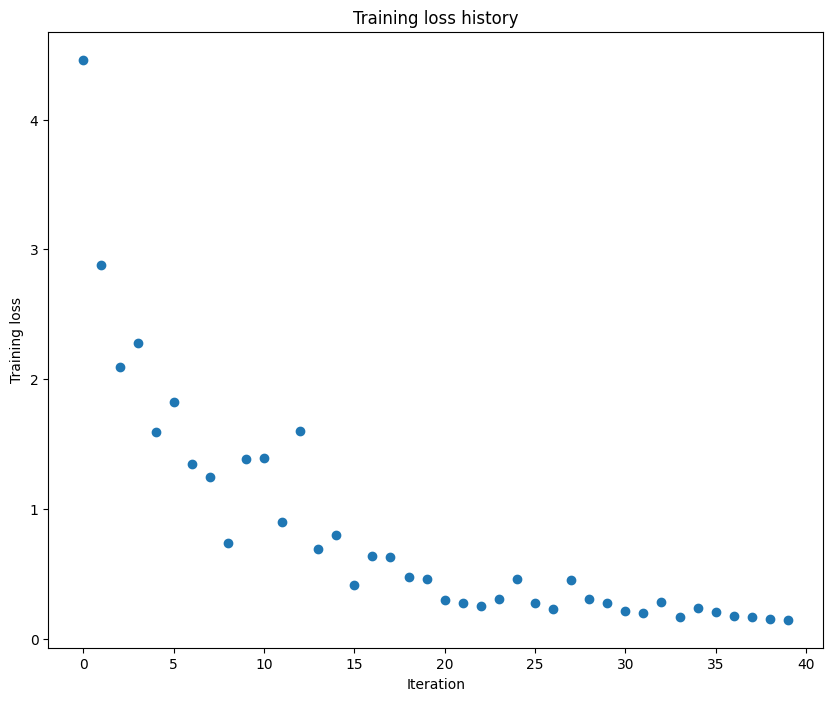

(Iteration 1 / 40) loss: 3.947891
(Epoch 0 / 20) train acc: 0.280000; val_acc: 0.232044
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.182320
(Epoch 2 / 20) train acc: 0.140000; val_acc: 0.099448
(Epoch 3 / 20) train acc: 0.140000; val_acc: 0.082873
(Epoch 4 / 20) train acc: 0.140000; val_acc: 0.088398
(Epoch 5 / 20) train acc: 0.220000; val_acc: 0.226519
(Iteration 11 / 40) loss: 2.693737
(Epoch 6 / 20) train acc: 0.140000; val_acc: 0.154696
(Epoch 7 / 20) train acc: 0.300000; val_acc: 0.171271
(Epoch 8 / 20) train acc: 0.280000; val_acc: 0.198895
(Epoch 9 / 20) train acc: 0.300000; val_acc: 0.232044
(Epoch 10 / 20) train acc: 0.440000; val_acc: 0.303867
(Iteration 21 / 40) loss: 1.966748
(Epoch 11 / 20) train acc: 0.480000; val_acc: 0.386740
(Epoch 12 / 20) train acc: 0.340000; val_acc: 0.265193
(Epoch 13 / 20) train acc: 0.380000; val_acc: 0.226519
(Epoch 14 / 20) train acc: 0.360000; val_acc: 0.281768
(Epoch 15 / 20) train acc: 0.520000; val_acc: 0.270718
(Iteration 31 / 40) loss: 

In [17]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.
import itertools

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-2   # Experiment with this!
learning_rate = 1e-4  # Experiment with this!

learning_rates = [1e-2, 1e-1]
weight_scales = [1e-1]

for lr in learning_rates:
    for ws in weight_scales:
        model = FullyConnectedNet([100, 100], input_dim=8*8, weight_scale=ws, dtype=np.float64)

        solver = Solver(model, small_data,
                        print_every=10, num_epochs=20, batch_size=25,
                        update_rule='sgd',
                        optim_config={
                          'learning_rate': lr,
                        }
                 )
        solver.train()
        
        # Проверяем достижение train acc равного 1.00
        if solver.train_acc_history[-1] == 1.00:
            print("Learning Rate:", lr)
            print("Weight Scale:", ws)
            print("Train acc:", solver.train_acc_history[-1])
            plt.plot(solver.loss_history, 'o')
            plt.title('Training loss history')
            plt.xlabel('Iteration')
            plt.ylabel('Training loss')
            plt.show()
            break  # Прерываем внутренний цикл после достижения требуемого train acc


Повторите эксперимент, описанный выше, для пятислойной сети.

(Iteration 1 / 40) loss: 82.684497
(Epoch 0 / 20) train acc: 0.100000; val_acc: 0.071823
(Epoch 1 / 20) train acc: 0.120000; val_acc: 0.171271
(Epoch 2 / 20) train acc: 0.140000; val_acc: 0.143646
(Epoch 3 / 20) train acc: 0.200000; val_acc: 0.204420
(Epoch 4 / 20) train acc: 0.500000; val_acc: 0.254144
(Epoch 5 / 20) train acc: 0.700000; val_acc: 0.292818
(Iteration 11 / 40) loss: 1.054296
(Epoch 6 / 20) train acc: 0.760000; val_acc: 0.320442
(Epoch 7 / 20) train acc: 0.740000; val_acc: 0.375691
(Epoch 8 / 20) train acc: 0.820000; val_acc: 0.392265
(Epoch 9 / 20) train acc: 0.960000; val_acc: 0.403315
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.425414
(Iteration 21 / 40) loss: 0.090944
(Epoch 11 / 20) train acc: 0.980000; val_acc: 0.441989
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.430939
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.436464
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.430939
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.441989
(Iteration 31 / 40) loss:

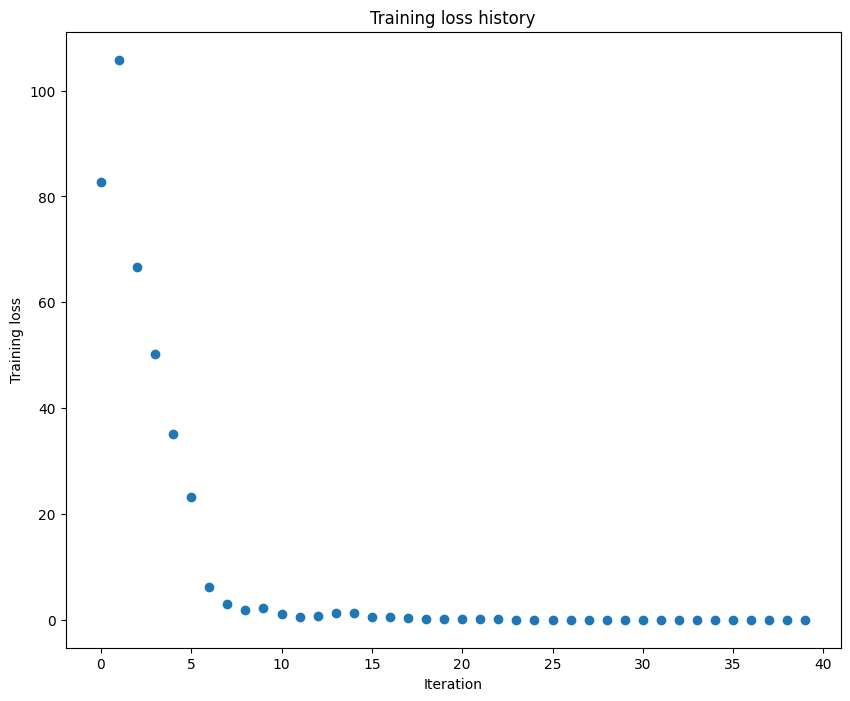

(Iteration 1 / 40) loss: 46.605575
(Epoch 0 / 20) train acc: 0.180000; val_acc: 0.121547
(Epoch 1 / 20) train acc: 0.260000; val_acc: 0.182320
(Epoch 2 / 20) train acc: 0.340000; val_acc: 0.160221
(Epoch 3 / 20) train acc: 0.420000; val_acc: 0.204420
(Epoch 4 / 20) train acc: 0.480000; val_acc: 0.270718
(Epoch 5 / 20) train acc: 0.580000; val_acc: 0.325967
(Iteration 11 / 40) loss: 2.429860
(Epoch 6 / 20) train acc: 0.800000; val_acc: 0.331492
(Epoch 7 / 20) train acc: 0.780000; val_acc: 0.370166
(Epoch 8 / 20) train acc: 0.860000; val_acc: 0.342541
(Epoch 9 / 20) train acc: 0.840000; val_acc: 0.337017
(Epoch 10 / 20) train acc: 0.920000; val_acc: 0.364641
(Iteration 21 / 40) loss: 0.192133
(Epoch 11 / 20) train acc: 0.960000; val_acc: 0.408840
(Epoch 12 / 20) train acc: 0.980000; val_acc: 0.386740
(Epoch 13 / 20) train acc: 0.980000; val_acc: 0.364641
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.381215
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.386740
(Iteration 31 / 40) loss:

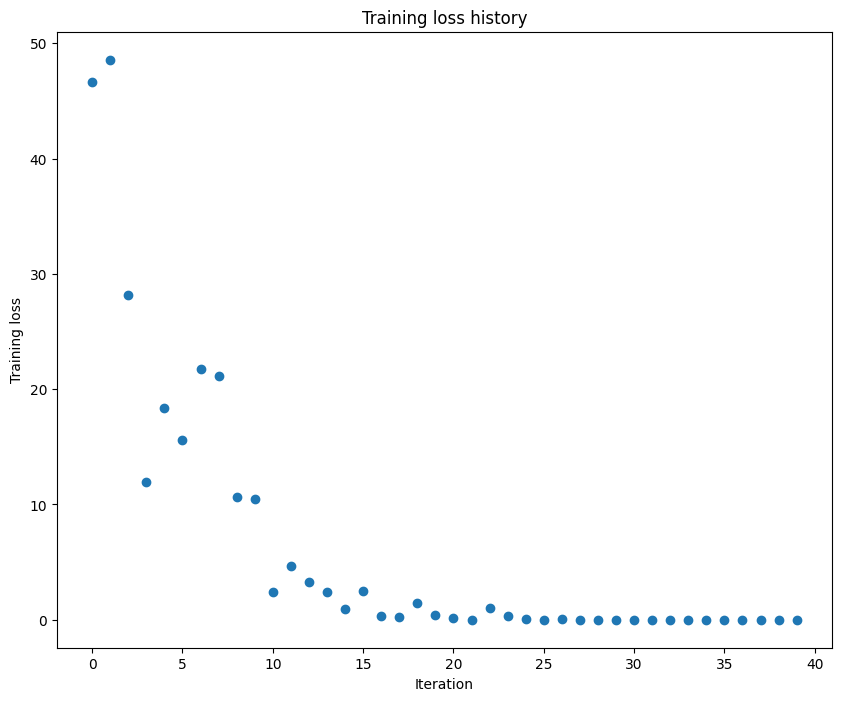

In [18]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rates = [ 1e-2, 1e-3]
weight_scales = [ 2e-1, 2e-2]

for lr in learning_rates:
    for ws in weight_scales:
        model = FullyConnectedNet([100, 100, 100, 100],input_dim=8*8, weight_scale=ws, dtype=np.float64)
        
        solver = Solver(model, small_data,
                        print_every=10, num_epochs=20, batch_size=25,
                        update_rule='sgd',
                        optim_config={
                          'learning_rate': lr,
                        }
                 )
        solver.train()
        
        # Проверяем достижение train acc равного 1.00
        if solver.train_acc_history[-1] == 1.00:
            print("Learning Rate:", lr)
            print("Weight Scale:", ws)
            print("Train acc:", solver.train_acc_history[-1])
            plt.plot(solver.loss_history, 'o')
            plt.title('Training loss history')
            plt.xlabel('Iteration')
            plt.ylabel('Training loss')
            plt.show()
            break  # Прерываем внутренний цикл после достижения требуемого train acc

Сделайте выводы по проведенному эксперименту. 

Трехслойная сеть: train_acc = 1, val_acc = 0.65

Пятислойная сеть: train_acc = 1, val_acc = 0.38

Следовательно, пятислойная сеть переобучается "сильнее", чем трехслойная.


Ранее обновление весов проходило по правилу SGD. Теперь попробуйте реализовать стохастический градиентный спуск с импульсом (SGD+momentum). http://cs231n.github.io/neural-networks-3/#sgd Реализуйте sgd_momentum в scripts/optim.py  и запустите проверку. 

In [19]:
from scripts.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Сравните результаты обучения шестислойной сети, обученной классическим градиентным спуском и адаптивным алгоритмом с импульсом. Какой алгоритм сходится быстрее.

running with  sgd
(Iteration 1 / 70) loss: 2.299505
(Epoch 0 / 5) train acc: 0.178000; val_acc: 0.226519
(Iteration 11 / 70) loss: 2.298851
(Epoch 1 / 5) train acc: 0.186000; val_acc: 0.226519
(Iteration 21 / 70) loss: 2.300378
(Epoch 2 / 5) train acc: 0.190000; val_acc: 0.198895
(Iteration 31 / 70) loss: 2.300182
(Iteration 41 / 70) loss: 2.298120
(Epoch 3 / 5) train acc: 0.194000; val_acc: 0.193370
(Iteration 51 / 70) loss: 2.299386
(Epoch 4 / 5) train acc: 0.194000; val_acc: 0.198895
(Iteration 61 / 70) loss: 2.298266
(Epoch 5 / 5) train acc: 0.202000; val_acc: 0.176796

running with  sgd_momentum
(Iteration 1 / 70) loss: 2.303321
(Epoch 0 / 5) train acc: 0.043000; val_acc: 0.038674
(Iteration 11 / 70) loss: 2.296524
(Epoch 1 / 5) train acc: 0.163000; val_acc: 0.110497
(Iteration 21 / 70) loss: 2.297929
(Epoch 2 / 5) train acc: 0.235000; val_acc: 0.232044
(Iteration 31 / 70) loss: 2.291414
(Iteration 41 / 70) loss: 2.287393
(Epoch 3 / 5) train acc: 0.257000; val_acc: 0.198895
(Itera

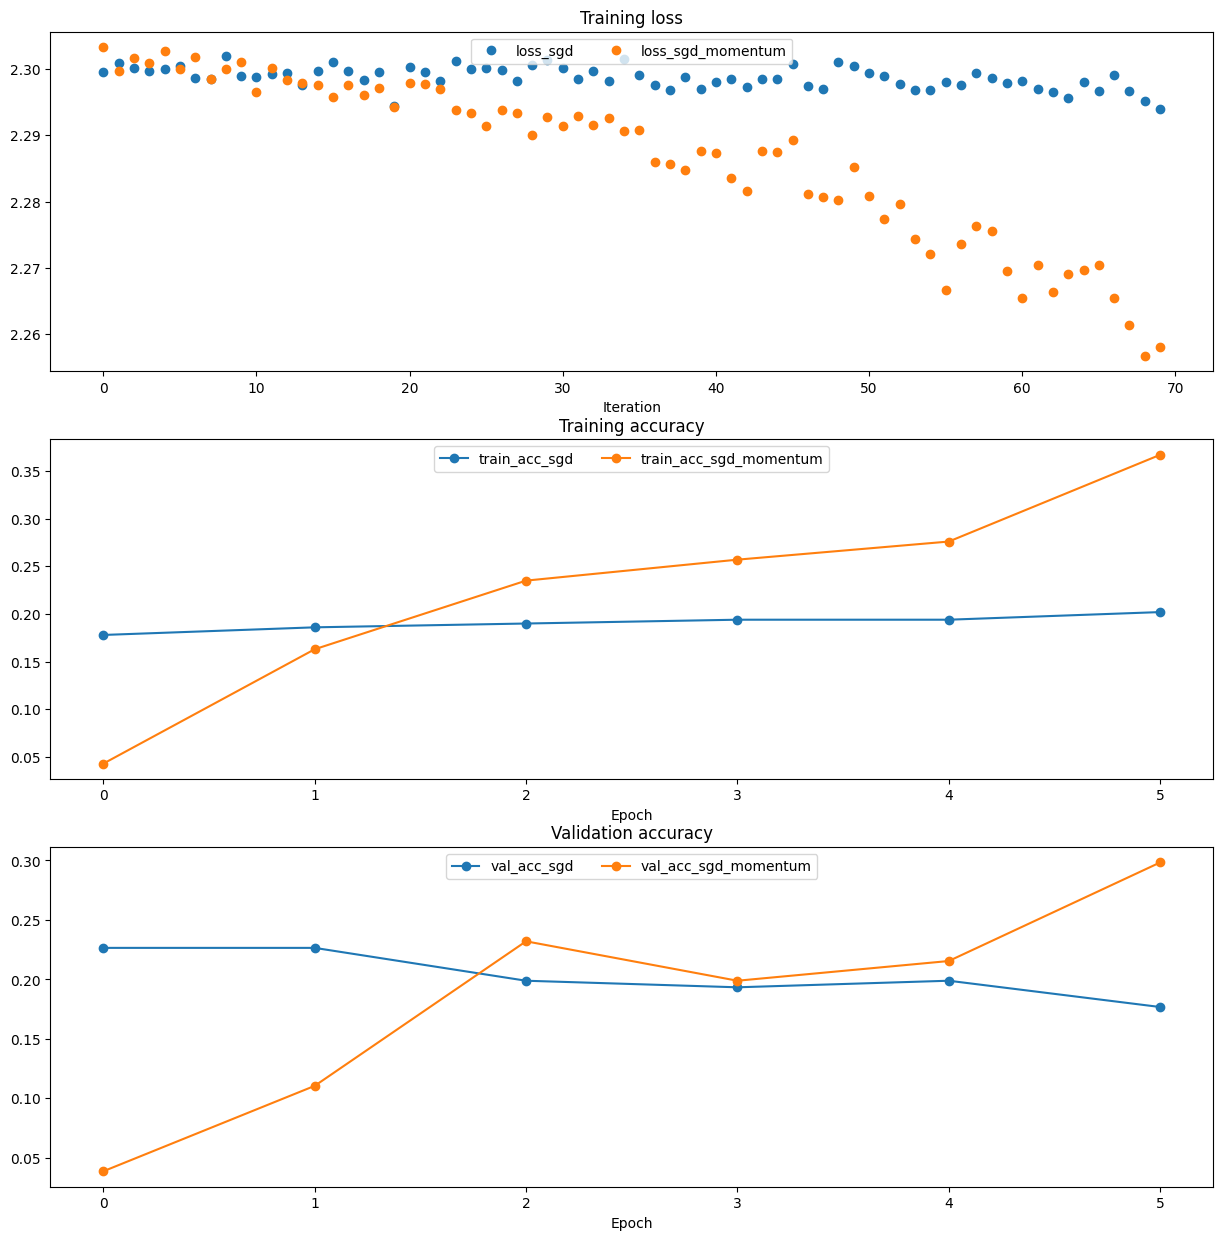

In [21]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], input_dim=8*8, weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 5e-3,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label="loss_%s" % update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label="train_acc_%s" % update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label="val_acc_%s" % update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

Реализуйте алгоритмы RMSProp [1] and Adam [2] с коррекцией смещения  - методы rmsprop и adam . 


[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [22]:
# Test RMSProp implementation
from scripts.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [23]:
# Test Adam implementation
from scripts.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Обучите пару глубоких сетей с испольованием RMSProp и Adam алгоритмов обновления весов и сравните результаты обучения.

running with  adam
(Iteration 1 / 70) loss: 2.302192
(Epoch 0 / 5) train acc: 0.187000; val_acc: 0.182320
(Iteration 11 / 70) loss: 2.205069
(Epoch 1 / 5) train acc: 0.598000; val_acc: 0.563536
(Iteration 21 / 70) loss: 1.593058
(Epoch 2 / 5) train acc: 0.747000; val_acc: 0.701657
(Iteration 31 / 70) loss: 0.800950
(Iteration 41 / 70) loss: 0.576355
(Epoch 3 / 5) train acc: 0.857000; val_acc: 0.839779
(Iteration 51 / 70) loss: 0.372780
(Epoch 4 / 5) train acc: 0.909000; val_acc: 0.906077
(Iteration 61 / 70) loss: 0.215886
(Epoch 5 / 5) train acc: 0.920000; val_acc: 0.889503

running with  rmsprop
(Iteration 1 / 70) loss: 2.302679
(Epoch 0 / 5) train acc: 0.142000; val_acc: 0.093923
(Iteration 11 / 70) loss: 2.238950
(Epoch 1 / 5) train acc: 0.251000; val_acc: 0.265193
(Iteration 21 / 70) loss: 2.062844
(Epoch 2 / 5) train acc: 0.554000; val_acc: 0.497238
(Iteration 31 / 70) loss: 1.794523
(Iteration 41 / 70) loss: 1.581400
(Epoch 3 / 5) train acc: 0.688000; val_acc: 0.629834
(Iteration

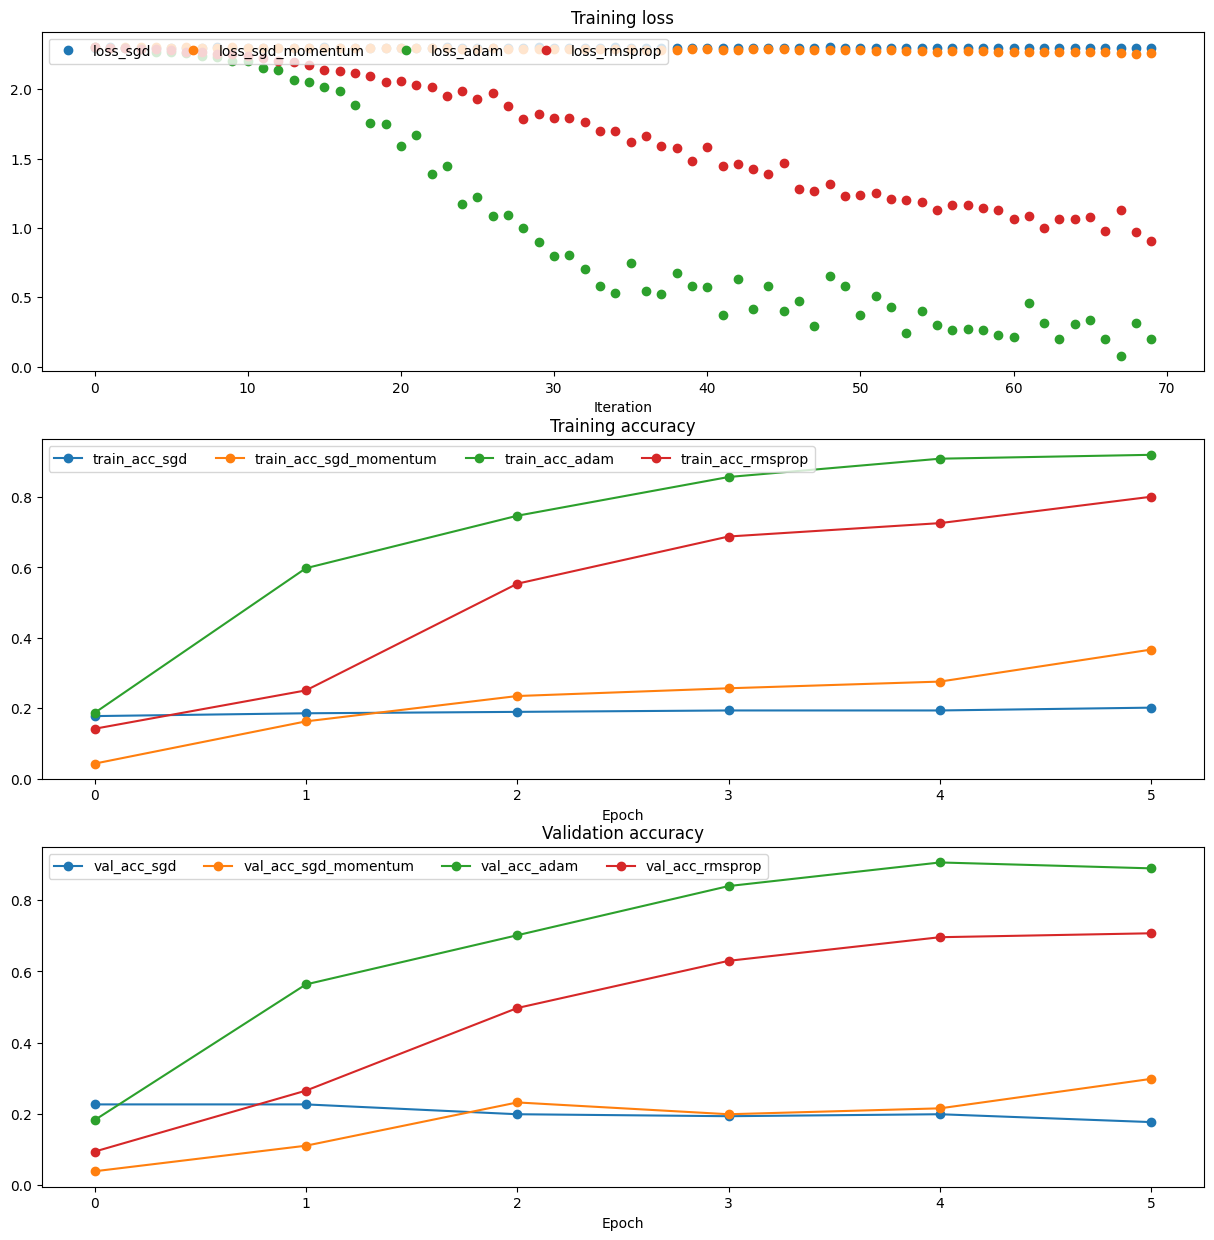

In [26]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], input_dim=8*8, weight_scale=5e-2)

    solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
    solvers[update_rule] = solver
    solver.train()
    print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label="loss_%s" % update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label="train_acc_%s" % update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label="val_acc_%s" % update_rule)

for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper left', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

Получите лучшую полносвязную сеть для классификации вашего набора данных. На наборе CIFAR-10 необходимо получить accuracy не ниже 50 % на валидационном наборе.

In [27]:
import itertools
best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

layers = [[100, 100]]
learning_rates = [1e-2]
regs = [1e-3]
decays = [0.95]
weight_scales = [1e-1]

best_accuracy = 0
best_lr, best_ws, best_layer, best_reg, best_lrd = 0, 0, 0, 0, 0

for lr, ws, layer, reg, lrd in itertools.product(learning_rates, weight_scales, layers, regs, decays):

    model = FullyConnectedNet(layer, input_dim=8*8, reg=reg, weight_scale=ws)
    solver = Solver(model, data, num_epochs=20, batch_size=100, update_rule='adam',
        optim_config={
            'learning_rate': lr,
            'decay_rate': lrd
        }
        )
    solver.train()
    if solver.val_acc_history[-1] > best_accuracy:
        best_accuracy = solver.val_acc_history[-1]
        best_lr = lr
        best_ws = ws
        best_layer = layer
        best_reg = reg
        best_lrd = lrd
        best_model = model

print('Best lr', best_lr)
print('Best ws', best_ws)
print('Best layer', best_layer)
print('Best reg', best_reg)
print('Best lrd', best_lrd)
print('Best acc', best_accuracy)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 280) loss: 5.693015
(Epoch 0 / 20) train acc: 0.157000; val_acc: 0.187845
(Iteration 11 / 280) loss: 1.205779
(Epoch 1 / 20) train acc: 0.859000; val_acc: 0.889503
(Iteration 21 / 280) loss: 0.397223
(Epoch 2 / 20) train acc: 0.946000; val_acc: 0.922652
(Iteration 31 / 280) loss: 0.159716
(Iteration 41 / 280) loss: 0.301898
(Epoch 3 / 20) train acc: 0.962000; val_acc: 0.950276
(Iteration 51 / 280) loss: 0.177626
(Epoch 4 / 20) train acc: 0.976000; val_acc: 0.955801
(Iteration 61 / 280) loss: 0.119822
(Epoch 5 / 20) train acc: 0.987000; val_acc: 0.950276
(Iteration 71 / 280) loss: 0.107540
(Iteration 81 / 280) loss: 0.123425
(Epoch 6 / 20) train acc: 0.982000; val_acc: 0.955801
(Iteration 91 / 280) loss: 0.099862
(Epoch 7 / 20) train acc: 0.988000; val_acc: 0.961326
(Iteration 101 / 280) loss: 0.097200
(Iteration 111 / 280) loss: 0.119903
(Epoch 8 / 20) train acc: 0.982000; val_acc: 0.939227
(Iteration 121 / 280) loss: 0.092274
(Epoch 9 / 20) train acc: 0.985000; val_acc:

Получите оценку accuracy для валидационной и тестовой выборок. 

In [28]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.9834254143646409
Test set accuracy:  0.988950276243094


# Нормализация по мини-батчам

Идея нормализации по мини-батчам предложена в работе [1]

[1] Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift", ICML 2015.

Реализуйте прямой проход для слоя батч-нормализации - функция batchnorm_forward в scripts/layers.py . Проверьте свою реализацию, запустив следующий код:

In [29]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization   

# Simulate the forward pass for a two-layer network
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print_mean_std(a,axis=0)

gamma = np.ones((D3,))
beta = np.zeros((D3,))
# Means should be close to zero and stds close to one
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
# Now means should be close to beta and stds close to gamma
print('After batch normalization (gamma=', gamma, ', beta=', beta, ')')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

Before batch normalization:
  means:  [ -2.3814598  -13.18038246   1.91780462]
  stds:   [27.18502186 34.21455511 37.68611762]

After batch normalization (gamma=1, beta=0)
  means:  [5.32907052e-17 5.49560397e-17 9.71445147e-18]
  stds:   [0.99999999 1.         1.        ]

After batch normalization (gamma= [1. 2. 3.] , beta= [11. 12. 13.] )
  means:  [11. 12. 13.]
  stds:   [0.99999999 1.99999999 2.99999999]



In [30]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)

for t in range(50):
  X = np.random.randn(N, D1)
  a = np.maximum(0, X.dot(W1)).dot(W2)
  batchnorm_forward(a, gamma, beta, bn_param)

bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print_mean_std(a_norm,axis=0)

After batch normalization (test-time):
  means:  [-0.03927354 -0.04349152 -0.10452688]
  stds:   [1.01531428 1.01238373 0.97819988]



Реализуйте обратный проход в функции batchnorm_backward.

In [31]:
# Gradient check batchnorm backward pass
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, a, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, b, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)
#You should expect to see relative errors between 1e-13 and 1e-8
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.7029235612572515e-09
dgamma error:  7.420414216247087e-13
dbeta error:  2.8795057655839487e-12


Измените реализацию класса FullyConnectedNet, добавив батч-нормализацию. 
Если флаг normalization == "batchnorm", то вам необходимо вставить слой батч-нормализации перед каждым слоем активации ReLU, кроме выхода сети. 

In [32]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

# You should expect losses between 1e-4~1e-10 for W, 
# losses between 1e-08~1e-10 for b,
# and losses between 1e-08~1e-09 for beta and gammas.
for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64,
                            normalization='batchnorm')

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  if reg == 0: print()

Running check with reg =  0
Initial loss:  2.2611955101340957
W1 relative error: 1.10e-04
W2 relative error: 2.85e-06
W3 relative error: 4.05e-10
b1 relative error: 1.39e-09
b2 relative error: 2.22e-08
b3 relative error: 1.01e-10
beta1 relative error: 7.33e-09
beta2 relative error: 1.89e-09
gamma1 relative error: 6.96e-09
gamma2 relative error: 1.96e-09

Running check with reg =  3.14
Initial loss:  5.884829928987633
W1 relative error: 1.98e-06
W2 relative error: 2.29e-06
W3 relative error: 6.29e-10
b1 relative error: 5.55e-09
b2 relative error: 2.22e-08
b3 relative error: 2.10e-10
beta1 relative error: 6.65e-09
beta2 relative error: 4.23e-09
gamma1 relative error: 6.27e-09
gamma2 relative error: 5.28e-09


Обучите 6-ти слойную сеть на наборе из 1000 изображений с батч-нормализацией и без нее

In [33]:
np.random.seed(231)
# Try training a very deep net with batchnorm
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, input_dim=8*8, weight_scale=weight_scale, normalization='batchnorm')
model = FullyConnectedNet(hidden_dims, input_dim=8*8, weight_scale=weight_scale, normalization=None)

print('Solver with batch norm:')
bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True,print_every=20)
bn_solver.train()

print('\nSolver without batch norm:')
solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

Solver with batch norm:
(Iteration 1 / 200) loss: 2.352905
(Epoch 0 / 10) train acc: 0.100000; val_acc: 0.099448
(Epoch 1 / 10) train acc: 0.874000; val_acc: 0.823204
(Iteration 21 / 200) loss: 1.142692
(Epoch 2 / 10) train acc: 0.976000; val_acc: 0.961326
(Iteration 41 / 200) loss: 0.648497
(Epoch 3 / 10) train acc: 0.985000; val_acc: 0.955801
(Iteration 61 / 200) loss: 0.346707
(Epoch 4 / 10) train acc: 0.983000; val_acc: 0.972376
(Iteration 81 / 200) loss: 0.216604
(Epoch 5 / 10) train acc: 0.988000; val_acc: 0.955801
(Iteration 101 / 200) loss: 0.137318
(Epoch 6 / 10) train acc: 0.998000; val_acc: 0.983425
(Iteration 121 / 200) loss: 0.061308
(Epoch 7 / 10) train acc: 0.993000; val_acc: 0.966851
(Iteration 141 / 200) loss: 0.057899
(Epoch 8 / 10) train acc: 0.983000; val_acc: 0.950276
(Iteration 161 / 200) loss: 0.055990
(Epoch 9 / 10) train acc: 0.995000; val_acc: 0.977901
(Iteration 181 / 200) loss: 0.058151
(Epoch 10 / 10) train acc: 0.996000; val_acc: 0.955801

Solver without b

Визуализируйте процесс обучения для двух сетей. Увеличилась ли скорость сходимости в случае с батч-нормализацией? Сделайте выводы. 

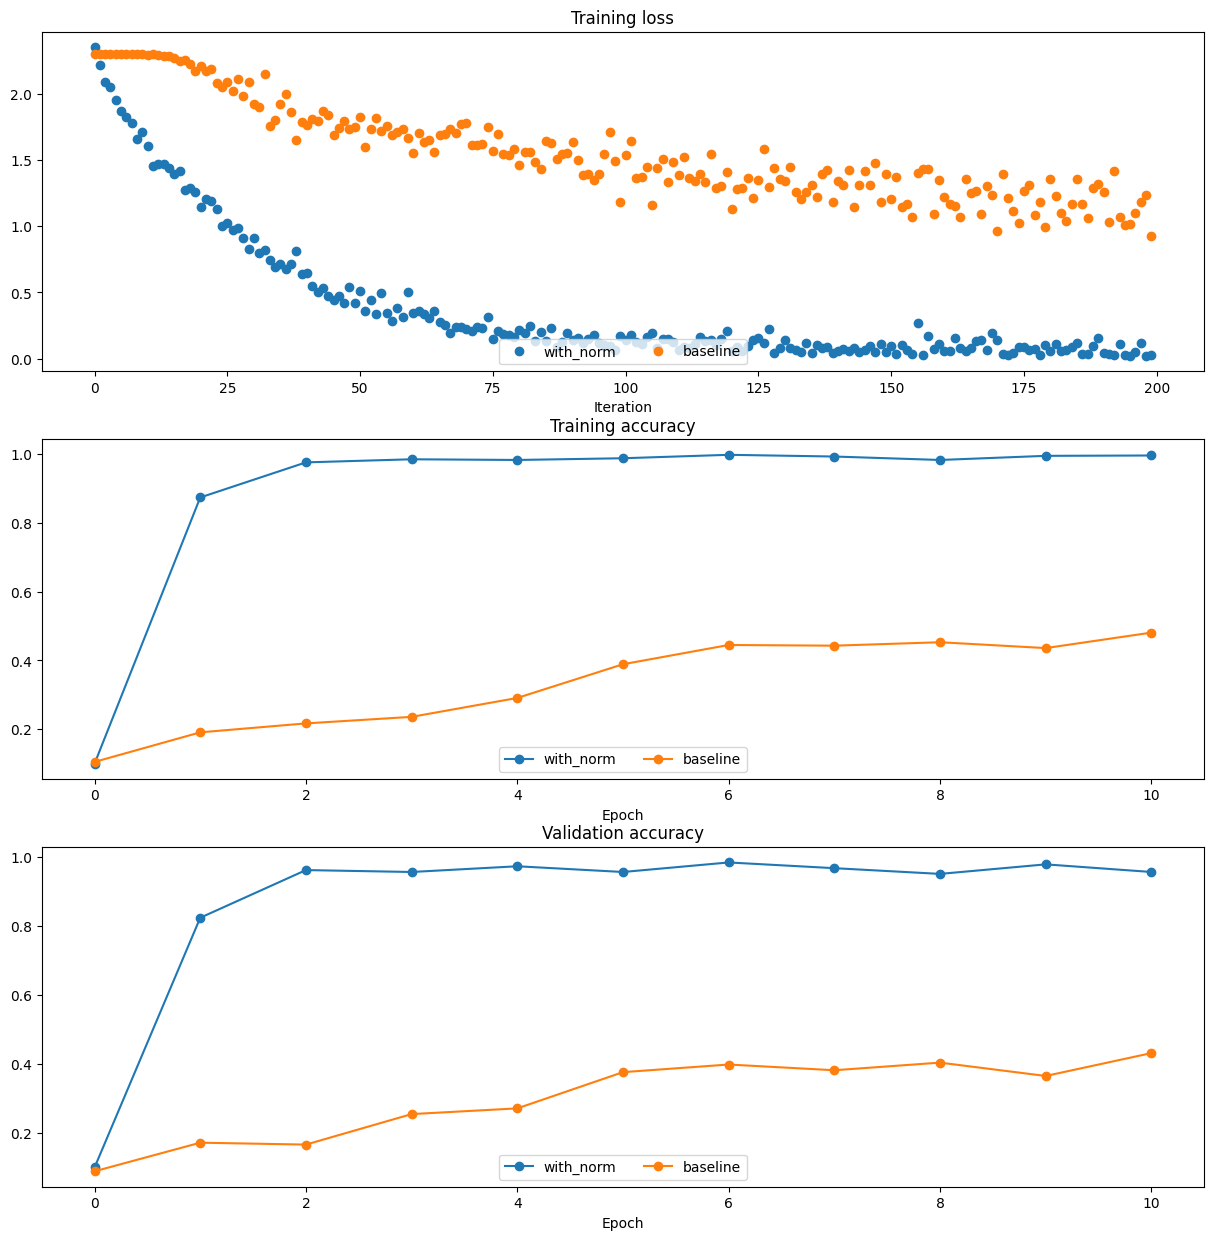

In [34]:
def plot_training_history(title, label, baseline, bn_solvers, plot_fn, bl_marker='.', bn_marker='.', labels=None):
    """utility function for plotting training history"""
    plt.title(title)
    plt.xlabel(label)
    bn_plots = [plot_fn(bn_solver) for bn_solver in bn_solvers]
    bl_plot = plot_fn(baseline)
    num_bn = len(bn_plots)
    for i in range(num_bn):
        label='with_norm'
        if labels is not None:
            label += str(labels[i])
        plt.plot(bn_plots[i], bn_marker, label=label)
    label='baseline'
    if labels is not None:
        label += str(labels[0])
    plt.plot(bl_plot, bl_marker, label=label)
    plt.legend(loc='lower center', ncol=num_bn+1) 

    
plt.subplot(3, 1, 1)
plot_training_history('Training loss','Iteration', solver, [bn_solver], \
                      lambda x: x.loss_history, bl_marker='o', bn_marker='o')
plt.subplot(3, 1, 2)
plot_training_history('Training accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.train_acc_history, bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 3)
plot_training_history('Validation accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.val_acc_history, bl_marker='-o', bn_marker='-o')

plt.gcf().set_size_inches(15, 15)
plt.show()

In [ ]:
С нормализацией по батчам скорость сходимости на валидационной выборке существенно увеличивается

Обучите 6-тислойную сеть с батч-нормализацией и без нее, используя разные размеры батча. Визуализируйте графики обучения. Сделайте выводы по результатам эксперимента. 

In [35]:
def run_batchsize_experiments(normalization_mode):
    np.random.seed(231)
    # Try training a very deep net with batchnorm
    hidden_dims = [100, 100, 100, 100, 100]
    num_train = 1000
    small_data = {
      'X_train': data['X_train'][:num_train],
      'y_train': data['y_train'][:num_train],
      'X_val': data['X_val'],
      'y_val': data['y_val'],
    }
    n_epochs=10
    weight_scale = 2e-2
    batch_sizes = [5,10,50]
    lr = 10**(-3.5)
    solver_bsize = batch_sizes[0]

    print('No normalization: batch size = ',solver_bsize)
    model = FullyConnectedNet(hidden_dims, input_dim=8*8, weight_scale=weight_scale, normalization=None)
    solver = Solver(model, small_data,
                    num_epochs=n_epochs, batch_size=solver_bsize,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                    },
                    verbose=False)
    solver.train()
    
    bn_solvers = []
    for i in range(len(batch_sizes)):
        b_size=batch_sizes[i]
        print('Normalization: batch size = ',b_size)
        bn_model = FullyConnectedNet(hidden_dims, input_dim=8*8, weight_scale=weight_scale, normalization=normalization_mode)
        bn_solver = Solver(bn_model, small_data,
                        num_epochs=n_epochs, batch_size=b_size,
                        update_rule='adam',
                        optim_config={
                          'learning_rate': lr,
                        },
                        verbose=False)
        bn_solver.train()
        bn_solvers.append(bn_solver)
        
    return bn_solvers, solver, batch_sizes

batch_sizes = [5,10,50]
bn_solvers_bsize, solver_bsize, batch_sizes = run_batchsize_experiments('batchnorm')

No normalization: batch size =  5
Normalization: batch size =  5
Normalization: batch size =  10
Normalization: batch size =  50


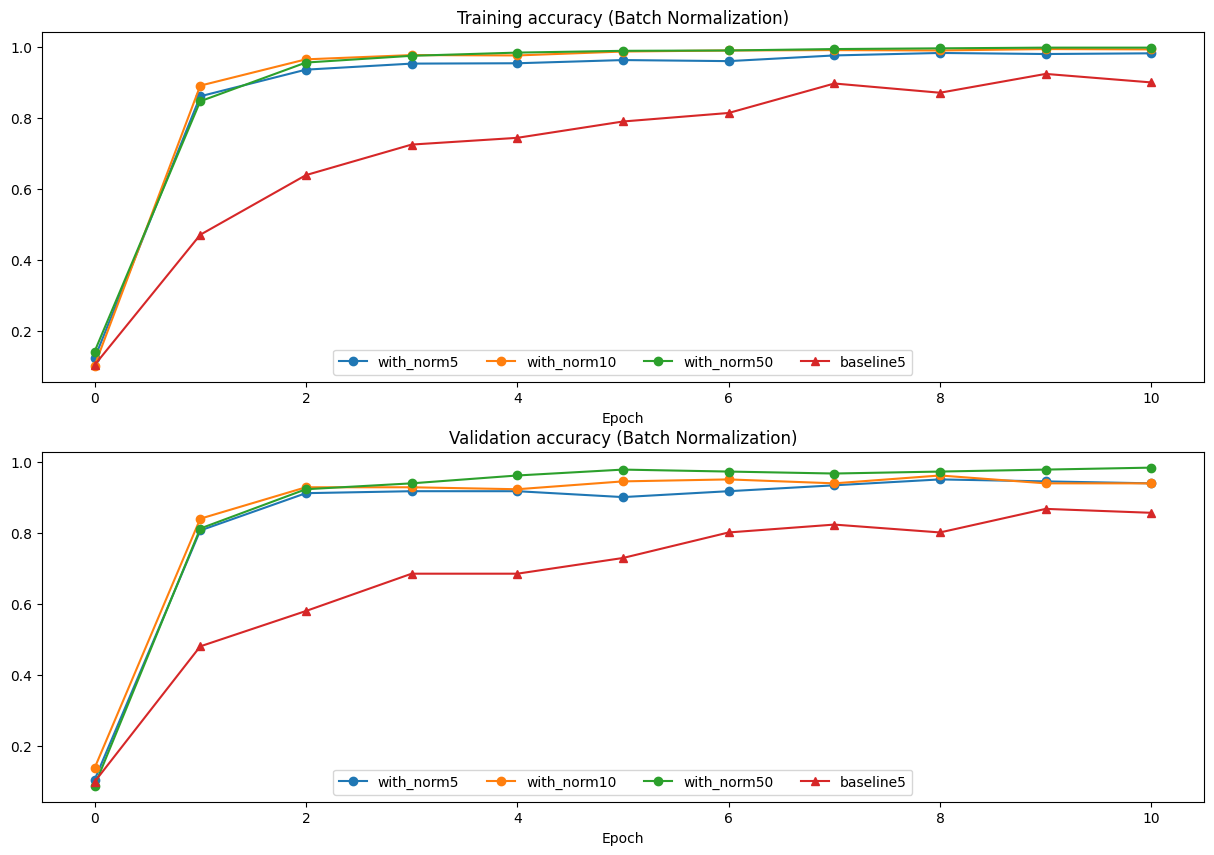

In [36]:
plt.subplot(2, 1, 1)
plot_training_history('Training accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)
plt.subplot(2, 1, 2)
plot_training_history('Validation accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)

plt.gcf().set_size_inches(15, 10)
plt.show()

In [ ]:
Исходя из результатов, видно, что размер батча практически не влияет на скорость сходимости на валидационной выборке

# Dropout

Реализуйте прямой проход для dropout-слоя в scripts/layers.py

http://cs231n.github.io/neural-networks-2/#reg

In [37]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for p in [0.25, 0.4, 0.7]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
  print()

Running tests with p =  0.25
Mean of input:  10.000207878477502
Mean of train-time output:  10.014059116977283
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.749784
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  10.000207878477502
Mean of train-time output:  9.977917658761159
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.600796
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  10.000207878477502
Mean of train-time output:  9.987811912159426
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.30074
Fraction of test-time output set to zero:  0.0



Реализуйте обратный проход для dropout-слоя

In [38]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less
print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.44560814873387e-11


Добавьте в реализацию класса FullyConnectedNet поддержку dropout. Если параметр dropout != 1, то добавьте в модель dropout-слой после каждого слоя активации. Проверьте свою реализацию

In [39]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [1, 0.75, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Relative errors should be around e-6 or less; Note that it's fine
  # if for dropout=1 you have W2 error be on the order of e-5.
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  print()

Running check with dropout =  1
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11

Running check with dropout =  0.75
Initial loss:  2.302371489704412
W1 relative error: 1.90e-07
W2 relative error: 4.76e-06
W3 relative error: 2.60e-08
b1 relative error: 4.73e-09
b2 relative error: 1.82e-09
b3 relative error: 1.70e-10

Running check with dropout =  0.5
Initial loss:  2.3042759220785896
W1 relative error: 3.11e-07
W2 relative error: 1.84e-08
W3 relative error: 5.35e-08
b1 relative error: 5.37e-09
b2 relative error: 2.99e-09
b3 relative error: 1.13e-10



Обучите две двухслойные сети с dropout-слоем (вероятность отсева 0,25) и без на наборе из 500 изображений. Визуализируйте графики обучения. Сделайте выводы по результатам эксперимента

In [41]:
# Train two identical nets, one with dropout and one without
np.random.seed(231)
num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [1, 0.25]
for dropout in dropout_choices:
  model = FullyConnectedNet([500],input_dim=8*8, dropout=dropout)
  print(dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver
  print()

1
(Iteration 1 / 125) loss: 2.309216
(Epoch 0 / 25) train acc: 0.282000; val_acc: 0.243094
(Epoch 1 / 25) train acc: 0.712000; val_acc: 0.696133
(Epoch 2 / 25) train acc: 0.812000; val_acc: 0.740331
(Epoch 3 / 25) train acc: 0.828000; val_acc: 0.740331
(Epoch 4 / 25) train acc: 0.872000; val_acc: 0.801105
(Epoch 5 / 25) train acc: 0.914000; val_acc: 0.867403
(Epoch 6 / 25) train acc: 0.938000; val_acc: 0.883978
(Epoch 7 / 25) train acc: 0.918000; val_acc: 0.850829
(Epoch 8 / 25) train acc: 0.932000; val_acc: 0.872928
(Epoch 9 / 25) train acc: 0.950000; val_acc: 0.911602
(Epoch 10 / 25) train acc: 0.952000; val_acc: 0.889503
(Epoch 11 / 25) train acc: 0.958000; val_acc: 0.911602
(Epoch 12 / 25) train acc: 0.964000; val_acc: 0.911602
(Epoch 13 / 25) train acc: 0.976000; val_acc: 0.911602
(Epoch 14 / 25) train acc: 0.976000; val_acc: 0.922652
(Epoch 15 / 25) train acc: 0.980000; val_acc: 0.928177
(Epoch 16 / 25) train acc: 0.976000; val_acc: 0.917127
(Epoch 17 / 25) train acc: 0.982000; v

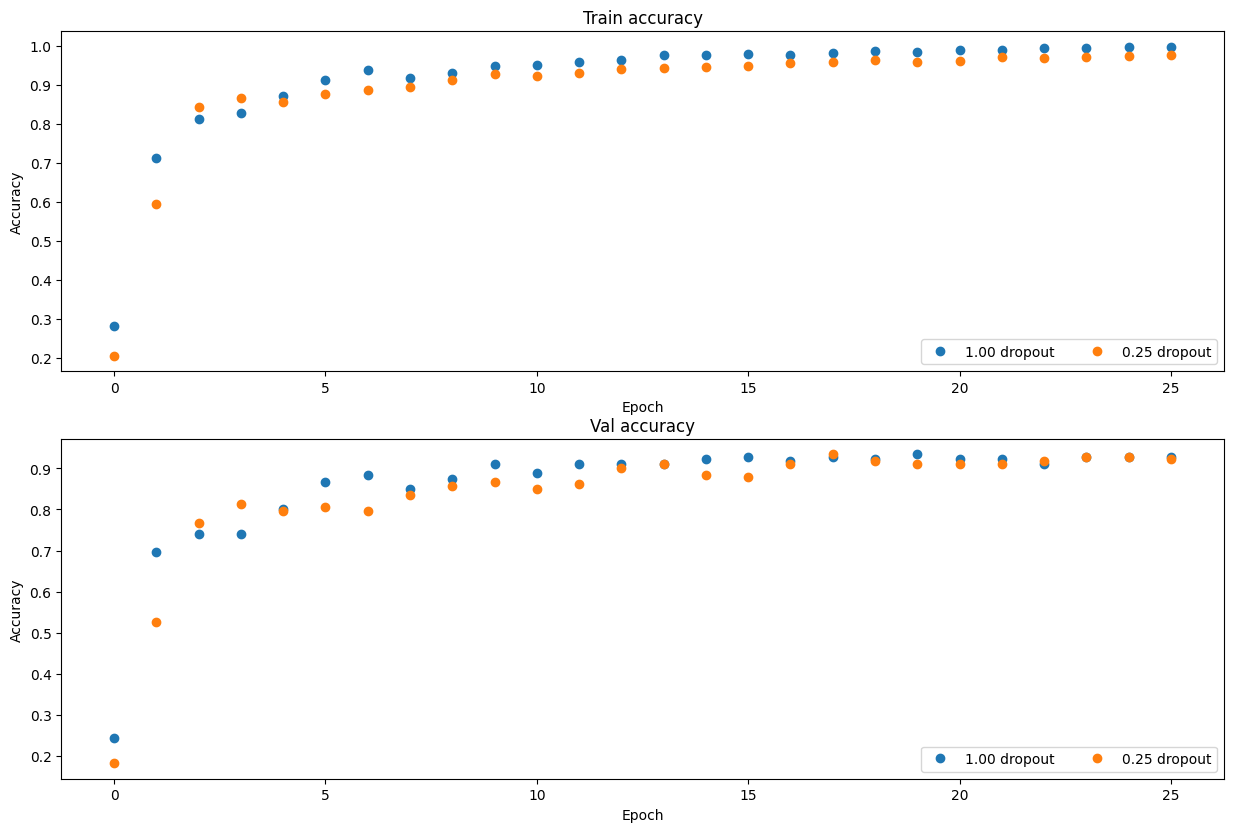

In [42]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

In [ ]:
Величина dropout практически не влияет на точность на валидационной выборке. Аналогично со скоростью сходимости. 

# Сверточные нейронные сети (CNN)

Реализуйте прямой проход для сверточного слоя - функция conv_forward_naive в scripts/layers.py юПроверьте свою реализацию, запустив код ниже 

In [43]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])

# Compare your output to ours; difference should be around e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.2121476417505994e-08


Реализуйте обратный проход - функция conv_backward_naive в scripts/layers.py

In [44]:
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be around e-8 or less.
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  2.9516731319807213e-09
dw error:  5.185597891706744e-10
db error:  2.1494967362289156e-11


Реализуйте прямой проход для max-pooling слоя -функция  max_pool_forward_naive в scripts/layers.py

In [45]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be on the order of e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

Testing max_pool_forward_naive function:
difference:  4.1666665157267834e-08


Реализуйте обратный проход для max-pooling слоя в max_pool_backward_naive . 

In [46]:
np.random.seed(231)
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# Your error should be on the order of e-12
print('Testing max_pool_backward_naive function:')
print('dx error: ', rel_error(dx, dx_num))

Testing max_pool_backward_naive function:
dx error:  3.27562514223145e-12


В скрипте scripts/fast_layers.py представлены быстрые реализации слоев свертки и пуллинга, написанных с использованием  Cython. 

Для компиляции выполните следующую команду в директории scripts

```bash
python setup.py build_ext --inplace
```


In [2]:
%load_ext Cython

[autoreload of pkg_resources failed: Traceback (most recent call last):
  File "C:\Users\1\PycharmProjects\6408_Lazutov_NN_lab3\.venv\lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\1\PycharmProjects\6408_Lazutov_NN_lab3\.venv\lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
  File "C:\Users\1\AppData\Local\Programs\Python\Python310\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "C:\Users\1\PycharmProjects\6408_Lazutov_NN_lab3\.venv\lib\site-packages\pkg_resources\__init__.py", line 120, in <module>
    parse_version = packaging.version.Version
AttributeError: module 'pkg_resources._vendor.packa

In [3]:
%cd scripts

C:\Users\1\PycharmProjects\6408_Lazutov_NN_lab3\scripts


C:\Users\1\PycharmProjects\6408_Lazutov_NN_lab3\.venv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
%pwd

'C:\\Users\\1\\PycharmProjects\\6408_Lazutov_NN_lab3\\scripts'

In [5]:
!python setup.py build_ext --inplace

Compiling im2col_cython.pyx because it changed.
[1/1] Cythonizing im2col_cython.pyx
im2col_cython.c
C:\Users\1\PycharmProjects\6408_Lazutov_NN_lab3\.venv\lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
im2col_cython.c(3194): warning C4244: =: ЇаҐ®Ўа §®ў ­ЁҐ "long" ў "char", ў®§¬®¦­  Ї®вҐап ¤ ­­ле
im2col_cython.c(3604): warning C4244: =: ЇаҐ®Ўа §®ў ­ЁҐ "npy_intp" ў "int", ў®§¬®¦­  Ї®вҐап ¤ ­­ле
im2col_cython.c(3613): warning C4244: =: ЇаҐ®Ўа §®ў ­ЁҐ "npy_intp" ў "int", ў®§¬®¦­  Ї®вҐап ¤ ­­ле
im2col_cython.c(3622): warning C4244: =: ЇаҐ®Ўа §®ў ­ЁҐ "npy_intp" ў "int", ў®§¬®¦­  Ї®вҐап ¤ ­­ле
im2col_cython.c(3631): warning C4244: =: ЇаҐ®Ўа §®ў ­ЁҐ "npy_intp" ў "int", ў®§¬®¦­  Ї®вҐап ¤ ­­ле
im2col_cython.c(4094): warning C4244: =: ЇаҐ®Ўа §®ў ­ЁҐ "npy_intp" ў "int", ў®§¬®¦­  Ї®вҐап ¤ ­­ле
im2col_cython.c(4103): warning C4244: =: ЇаҐ®Ўа §®ў ­ЁҐ "npy_intp" ў "int"

C:\Users\1\PycharmProjects\6408_Lazutov_NN_lab3\.venv\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\1\PycharmProjects\6408_Lazutov_NN_lab3\scripts\im2col_cython.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Сравните ваши реализации слоев свертки и пуллинга с быстрыми реализациями.

In [10]:
# Rel errors should be around e-9 or less
from scripts.fast_layers import conv_forward_fast, conv_backward_fast
from time import time
np.random.seed(231)
x = np.random.randn(100, 3, 31, 31)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)
dout = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t2 = time()

print('Testing conv_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive, dw_naive, db_naive = conv_backward_naive(dout, cache_naive)
t1 = time()
dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting conv_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))
print('dw difference: ', rel_error(dw_naive, dw_fast))
print('db difference: ', rel_error(db_naive, db_fast))

Testing conv_forward_fast:
Naive: 4.736262s
Fast: 0.008992s
Speedup: 526.722073x
Difference:  6.896970992227657e-11

Testing conv_backward_fast:
Naive: 8.973801s
Fast: 0.011150s
Speedup: 804.850850x
dx difference:  1.949764775345631e-11
dw difference:  4.957046344783224e-13
db difference:  0.0


In [11]:
# Relative errors should be close to 0.0
from scripts.fast_layers import max_pool_forward_fast, max_pool_backward_fast
np.random.seed(231)
x = np.random.randn(100, 3, 32, 32)
dout = np.random.randn(100, 3, 16, 16)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time()
out_naive, cache_naive = max_pool_forward_naive(x, pool_param)
t1 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t2 = time()

print('Testing pool_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive = max_pool_backward_naive(dout, cache_naive)
t1 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting pool_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))

Testing pool_forward_fast:
Naive: 0.483705s
fast: 0.006155s
speedup: 78.584034x
difference:  0.0

Testing pool_backward_fast:
Naive: 1.511853s
fast: 0.012283s
speedup: 123.088883x
dx difference:  0.0


В layer_utils.py вы можете найти  часто используемые комбинации слоев, используемых в сверточных сетях. Ознакомьтесь с ними и запустите код ниже для проверки их работы

In [12]:
from scripts.layer_utils import conv_relu_pool_forward, conv_relu_pool_backward
np.random.seed(231)
x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dout)

# Relative errors should be around e-8 or less
print('Testing conv_relu_pool')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu_pool
dx error:  9.591132621921372e-09
dw error:  5.802401370096438e-09
db error:  1.0146343411762047e-09


In [13]:
from scripts.layer_utils import conv_relu_forward, conv_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 8, 8)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_relu_forward(x, w, b, conv_param)
dx, dw, db = conv_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_forward(x, w, b, conv_param)[0], b, dout)

# Relative errors should be around e-8 or less
print('Testing conv_relu:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu:
dx error:  1.5218619980349303e-09
dw error:  2.702022646099404e-10
db error:  1.451272393591721e-10


Напишите реализацию класса ThreeLayerConvNet в scripts/classifiers/cnn.py . Вы можете использовать готовые реализации слоев и их комбинаций.

Проверьте вашу реализацию. Ожидается, что значение функции потерь softmax будет порядка `log(C)` для `C` классов для случая без регуляризации. В случае регуляризации значение функции потерь должно немного возрасти. 

In [20]:
model = ThreeLayerConvNet(input_dim=(3,32,32), num_filters=32, filter_size=7)

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.3025855279074525
Initial loss (with regularization):  2.5088809506805623


Проверьте реализацию обратного прохода

In [21]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
np.random.seed(231)
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(X, y)
# Errors should be small, but correct implementations may have
# relative errors up to the order of e-2
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 1.380104e-04
W2 max relative error: 1.822723e-02
W3 max relative error: 3.064049e-04
b1 max relative error: 3.477652e-05
b2 max relative error: 2.516375e-03
b3 max relative error: 7.945660e-10


Попробуйте добиться эффекта переобучения. Обучите модель на небольшом наборе данных.Сравните значения accuracy на обучающих данных и на валидационных. Визуализируйте графики обучения 

In [30]:
np.random.seed(42)

num_train = 100
small_data = {
    'X_train': data['X_train'][:num_train].reshape((-1, 1,8,8)),
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'].reshape((-1, 1,8,8)),
    'y_val': data['y_val']


}

model = ThreeLayerConvNet(weight_scale=1e-1)

solver = Solver(model, small_data,
                num_epochs=15, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 4e-3,
                },
                verbose=True, print_every=1)
solver.train()

(Iteration 1 / 30) loss: 11.201673
(Epoch 0 / 15) train acc: 0.070000; val_acc: 0.077348
(Iteration 2 / 30) loss: 8.388913
(Epoch 1 / 15) train acc: 0.150000; val_acc: 0.143646
(Iteration 3 / 30) loss: 14.015200
(Iteration 4 / 30) loss: 11.230663
(Epoch 2 / 15) train acc: 0.200000; val_acc: 0.209945
(Iteration 5 / 30) loss: 7.878975
(Iteration 6 / 30) loss: 6.890246
(Epoch 3 / 15) train acc: 0.370000; val_acc: 0.375691
(Iteration 7 / 30) loss: 5.069908
(Iteration 8 / 30) loss: 5.233399
(Epoch 4 / 15) train acc: 0.360000; val_acc: 0.353591
(Iteration 9 / 30) loss: 5.509853
(Iteration 10 / 30) loss: 2.667975
(Epoch 5 / 15) train acc: 0.460000; val_acc: 0.348066
(Iteration 11 / 30) loss: 2.781709
(Iteration 12 / 30) loss: 1.951314
(Epoch 6 / 15) train acc: 0.570000; val_acc: 0.447514
(Iteration 13 / 30) loss: 1.512490
(Iteration 14 / 30) loss: 1.617190
(Epoch 7 / 15) train acc: 0.580000; val_acc: 0.491713
(Iteration 15 / 30) loss: 1.113900
(Iteration 16 / 30) loss: 1.261418
(Epoch 8 / 15)

In [31]:
# Print final training accuracy
print(
    "Small data training accuracy:",
    solver.check_accuracy(small_data['X_train'], small_data['y_train'])
)

Small data training accuracy: 0.94


In [32]:
# Print final validation accuracy
print(
    "Small data validation accuracy:",
    solver.check_accuracy(small_data['X_val'], small_data['y_val'])
)

Small data validation accuracy: 0.7624309392265194


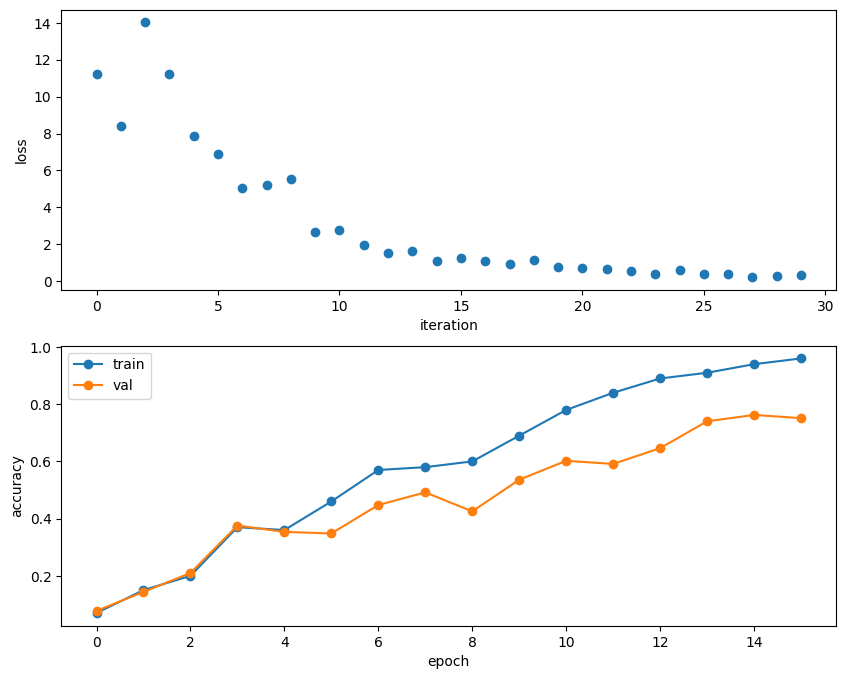

In [33]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

Обучите сеть на полном наборе данных. Выведите accuracy на обучающей и валидационной выборках

In [35]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001)
data = {
    'X_train': X_train.reshape((-1, 1, 8, 8)),
    'y_train': y_train,
    'X_val': X_val.reshape((-1, 1, 8, 8)),
    'y_val': y_val,
    'X_test': X_test.reshape((-1, 1, 8, 8)),
    'y_test': y_test
}
solver = Solver(model, data,
                num_epochs=15, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

(Iteration 1 / 420) loss: 2.302721
(Epoch 0 / 15) train acc: 0.096000; val_acc: 0.104972
(Iteration 21 / 420) loss: 1.655018
(Epoch 1 / 15) train acc: 0.685000; val_acc: 0.640884
(Iteration 41 / 420) loss: 0.795074
(Epoch 2 / 15) train acc: 0.837000; val_acc: 0.784530
(Iteration 61 / 420) loss: 0.669091
(Iteration 81 / 420) loss: 0.473263
(Epoch 3 / 15) train acc: 0.912000; val_acc: 0.917127
(Iteration 101 / 420) loss: 0.160088
(Epoch 4 / 15) train acc: 0.894000; val_acc: 0.861878
(Iteration 121 / 420) loss: 0.175217
(Epoch 5 / 15) train acc: 0.959000; val_acc: 0.944751
(Iteration 141 / 420) loss: 0.103724
(Iteration 161 / 420) loss: 0.122938
(Epoch 6 / 15) train acc: 0.958000; val_acc: 0.939227
(Iteration 181 / 420) loss: 0.102547
(Epoch 7 / 15) train acc: 0.948000; val_acc: 0.939227
(Iteration 201 / 420) loss: 0.096059
(Iteration 221 / 420) loss: 0.132235
(Epoch 8 / 15) train acc: 0.974000; val_acc: 0.977901
(Iteration 241 / 420) loss: 0.059779
(Epoch 9 / 15) train acc: 0.987000; val

In [36]:
# Print final training accuracy
print(
    "Full data training accuracy:",
    solver.check_accuracy(small_data['X_train'], small_data['y_train'])
)

Full data training accuracy: 0.98


In [37]:
# Print final validation accuracy
print(
    "Full data validation accuracy:",
    solver.check_accuracy(data['X_val'], data['y_val'])
)

Full data validation accuracy: 0.9834254143646409


Визуализируйте фильтры на первом слое обученной сети

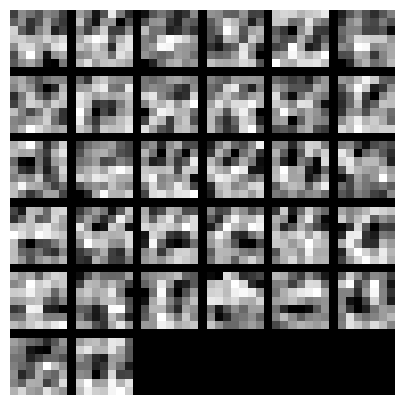

In [38]:
from scripts.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()